In [4]:
!nvidia-smi

Sun Jun 15 12:26:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# 📦 Setup
!pip install -q ultralytics

# 📚 Imports
import os, json, random, urllib.request
from pathlib import Path
from shutil import copy2
from zipfile import ZipFile
from collections import defaultdict
from tqdm import tqdm
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultraly

In [6]:
# 📥 COCO Download
urls = {
    "train2017.zip": "http://images.cocodataset.org/zips/train2017.zip",
    "annotations_trainval2017.zip": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
}
for fname, url in urls.items():
    if not os.path.exists(fname):
        print(f"⬇️ Lade {fname} ...")
        urllib.request.urlretrieve(url, fname)
    else:
        print(f"✔️ {fname} existiert bereits")


⬇️ Lade train2017.zip ...
⬇️ Lade annotations_trainval2017.zip ...


In [7]:
# 📂 Entpacken
def unzip(zip_path, extract_to="."):
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

if not os.path.exists("train2017"):
    unzip("train2017.zip")
if not os.path.exists("annotations"):
    unzip("annotations_trainval2017.zip")


In [8]:
# ⚙️ Konfiguration
coco_ann_file = 'annotations/instances_train2017.json'
images_dir = 'train2017'
output_dir = 'yolo_coco_person_sportsball'
target_classes = [0, 32]  # person + sports ball
split_ratios = {'train': 0.7, 'val': 0.2, 'test': 0.1}

os.makedirs(output_dir, exist_ok=True)

# 📚 COCO laden
with open(coco_ann_file) as f:
    coco = json.load(f)

cats = {cat['id']: cat['name'] for cat in coco['categories']}
cat_id_to_index = {cat_id: i for i, cat_id in enumerate(sorted(cats))}
filtered_cat_ids = [cat_id for cat_id, index in cat_id_to_index.items() if index in target_classes]

image_to_annotations = defaultdict(list)
for ann in coco['annotations']:
    if ann['category_id'] in filtered_cat_ids and ann['iscrowd'] == 0:
        image_to_annotations[ann['image_id']].append(ann)

image_id_to_info = {img['id']: img for img in coco['images'] if img['id'] in image_to_annotations}
image_ids = list(image_to_annotations.keys())

# 🔀 Aufteilen
random.seed(42)
random.shuffle(image_ids)
n = len(image_ids)
train_ids = image_ids[:int(n * split_ratios['train'])]
val_ids = image_ids[int(n * split_ratios['train']):int(n * (split_ratios['train'] + split_ratios['val']))]
test_ids = image_ids[int(n * (split_ratios['train'] + split_ratios['val'])):]
splits = {'train': train_ids, 'val': val_ids, 'test': test_ids}


In [9]:
# 📝 Labels + Bilder kopieren
for split, ids in splits.items():
    img_out = Path(output_dir) / 'images' / split
    lbl_out = Path(output_dir) / 'labels' / split
    img_out.mkdir(parents=True, exist_ok=True)
    lbl_out.mkdir(parents=True, exist_ok=True)

    for img_id in tqdm(ids, desc=f'📦 {split}'):
        img_info = image_id_to_info[img_id]
        anns = image_to_annotations[img_id]
        w, h = img_info['width'], img_info['height']
        file_name = img_info['file_name']
        src_img = os.path.join(images_dir, file_name)
        dst_img = img_out / file_name
        copy2(src_img, dst_img)

        label_lines = []
        for ann in anns:
            cat_idx = cat_id_to_index[ann['category_id']]
            if cat_idx not in target_classes:
                continue
            bbox = ann['bbox']
            x_center = (bbox[0] + bbox[2] / 2) / w
            y_center = (bbox[1] + bbox[3] / 2) / h
            width = bbox[2] / w
            height = bbox[3] / h
            class_id = target_classes.index(cat_idx)
            label_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        label_path = lbl_out / file_name.replace('.jpg', '.txt')
        with open(label_path, 'w') as f:
            f.write('\n'.join(label_lines))


📦 test: 100%|██████████| 6429/6429 [00:20<00:00, 319.01it/s]


In [10]:
# 📄 data.yaml schreiben
data_yaml = f"""path: {output_dir}
train: images/train
val: images/val
test: images/test
names:
  0: person
  1: sports ball
"""
with open(os.path.join(output_dir, 'data.yaml'), 'w') as f:
    f.write(data_yaml)

print("✅ YOLO-Datensatz bereit!")


✅ YOLO-Datensatz bereit!


In [ ]:
# 📦 Training starten
model = YOLO("yolov11n.pt")  # vortrainiertes YOLOv11n Basis-Modell

# Training konfigurieren und starten
results = model.train(
    data=f"{output_dir}/data.yaml",
    epochs=2,          # z.B. 30 Epochen, anpassen nach Bedarf
    batch=18,           # Batch-Größe (je nach GPU-RAM)
    imgsz=1280,         # Input Image Size
    name="yolov11n_coco_person_sportsball"
)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=18, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_coco_person_sportsball/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11n_coco_person_sportsball2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0

train: Scanning /content/yolo_coco_person_sportsball/labels/train.cache... 44996 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44996/44996 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 49.0±21.5 MB/s, size: 183.3 KB)


val: Scanning /content/yolo_coco_person_sportsball/labels/val.cache... 12855 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12855/12855 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov11n_coco_person_sportsball2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005625000000000001), 87 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to runs/detect/yolov11n_coco_person_sportsball2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      12.5G      1.278      1.644      1.416         92       1280: 100%|██████████| 2500/2500 [55:59<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 358/358 [05:56<00:00,  1.00it/s]


                   all      12855      52627      0.604      0.499      0.547      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      10.5G      1.264      1.247       1.41         84       1280: 100%|██████████| 2500/2500 [58:17<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 358/358 [05:54<00:00,  1.01it/s]


                   all      12855      52627      0.691      0.516      0.601      0.394

2 epochs completed in 2.121 hours.
Optimizer stripped from runs/detect/yolov11n_coco_person_sportsball2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolov11n_coco_person_sportsball2/weights/best.pt, 5.5MB

Validating runs/detect/yolov11n_coco_person_sportsball2/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   1%|          | 3/358 [00:04<08:28,  1.43s/it]

In [5]:
from ultralytics import YOLO
model = YOLO("runs/detect/yolov11n_coco_person_sportsball2/weights/best.pt")
output_dir = 'yolo_coco_person_sportsball'

In [6]:
# 📊 Validation (erzeugt automatisch Metriken + Confusion Matrix etc)
results = model.val(
    data=f"{output_dir}/data.yaml",
    imgsz=1280,
    save=True,           # speichert Ergebnisse in runs/val
    name="yolov11n_coco_person_sportsball_val"
)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 40.7±9.3 MB/s, size: 168.2 KB)


val: Scanning /content/yolo_coco_person_sportsball/labels/val.cache... 12855 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12855/12855 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 804/804 [04:39<00:00,  2.87it/s]


                   all      12855      52627      0.689      0.516      0.601      0.395
                person      12821      51384      0.837      0.529      0.706      0.445
           sports ball        864       1243      0.541      0.503      0.497      0.345
Speed: 0.8ms preprocess, 11.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/yolov11n_coco_person_sportsball_val


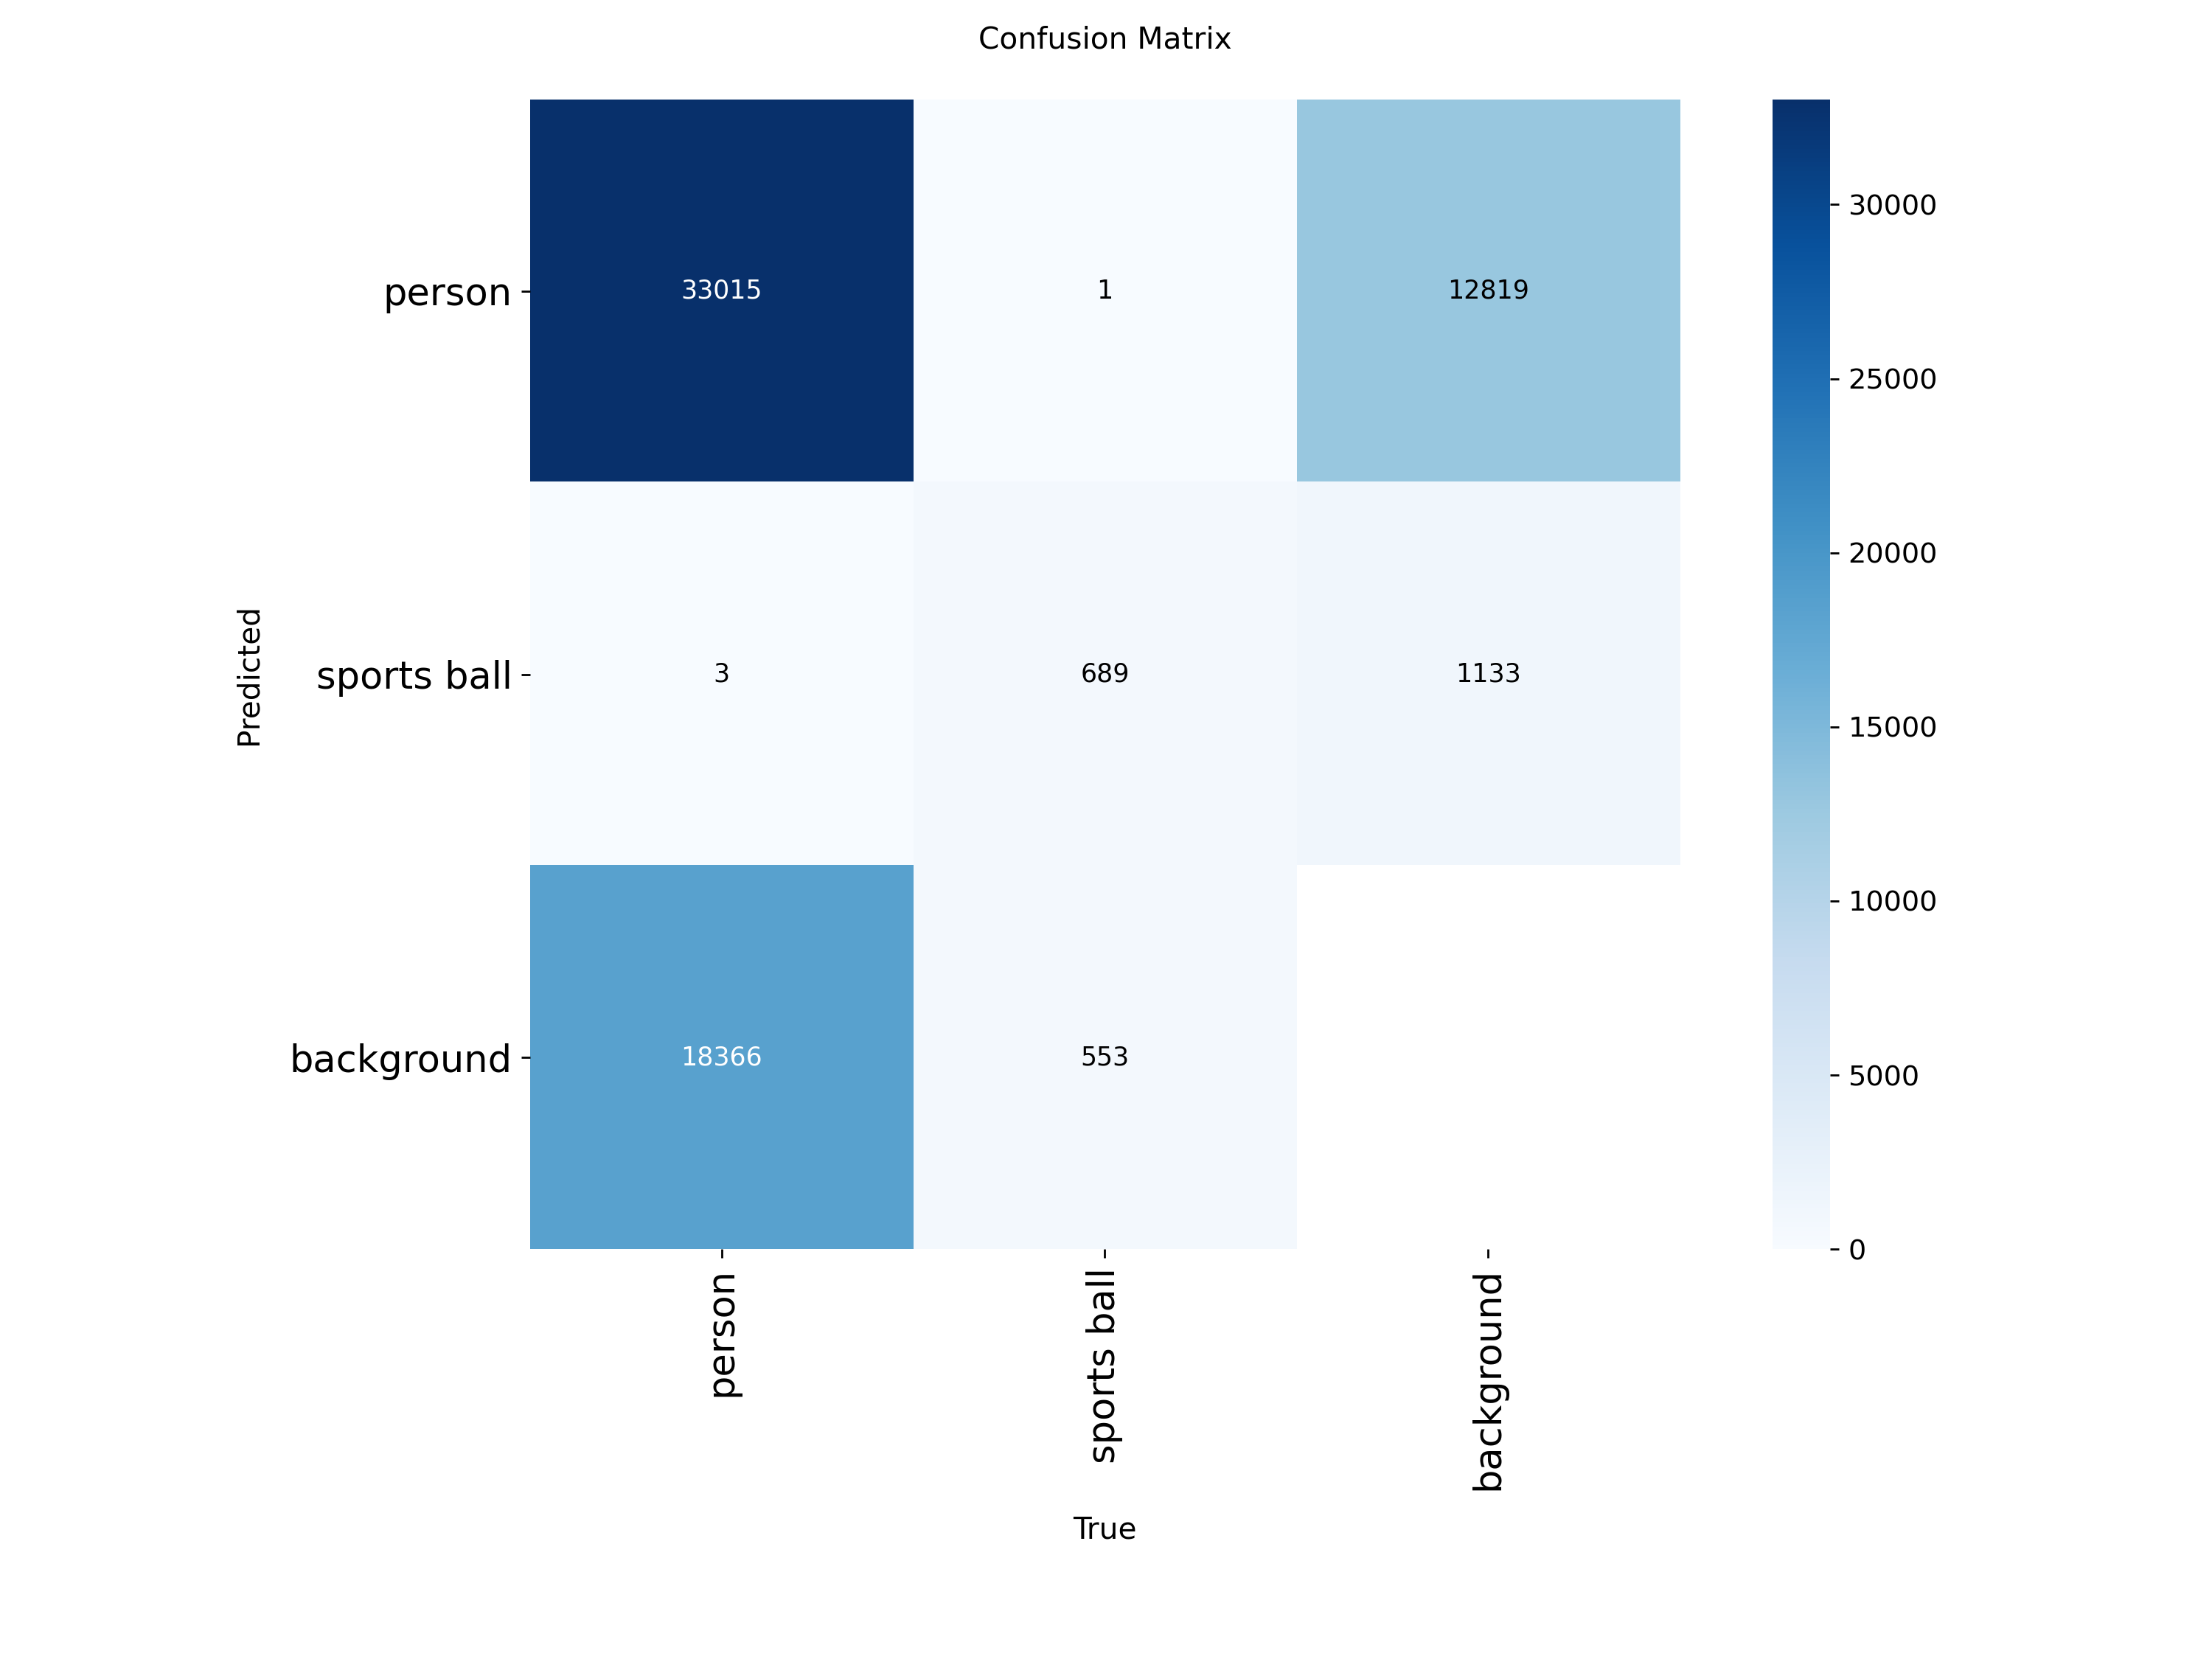

In [12]:
from IPython.display import Image
Image(filename=f'runs/detect/yolov11n_coco_person_sportsball_val/confusion_matrix.png', width=600)


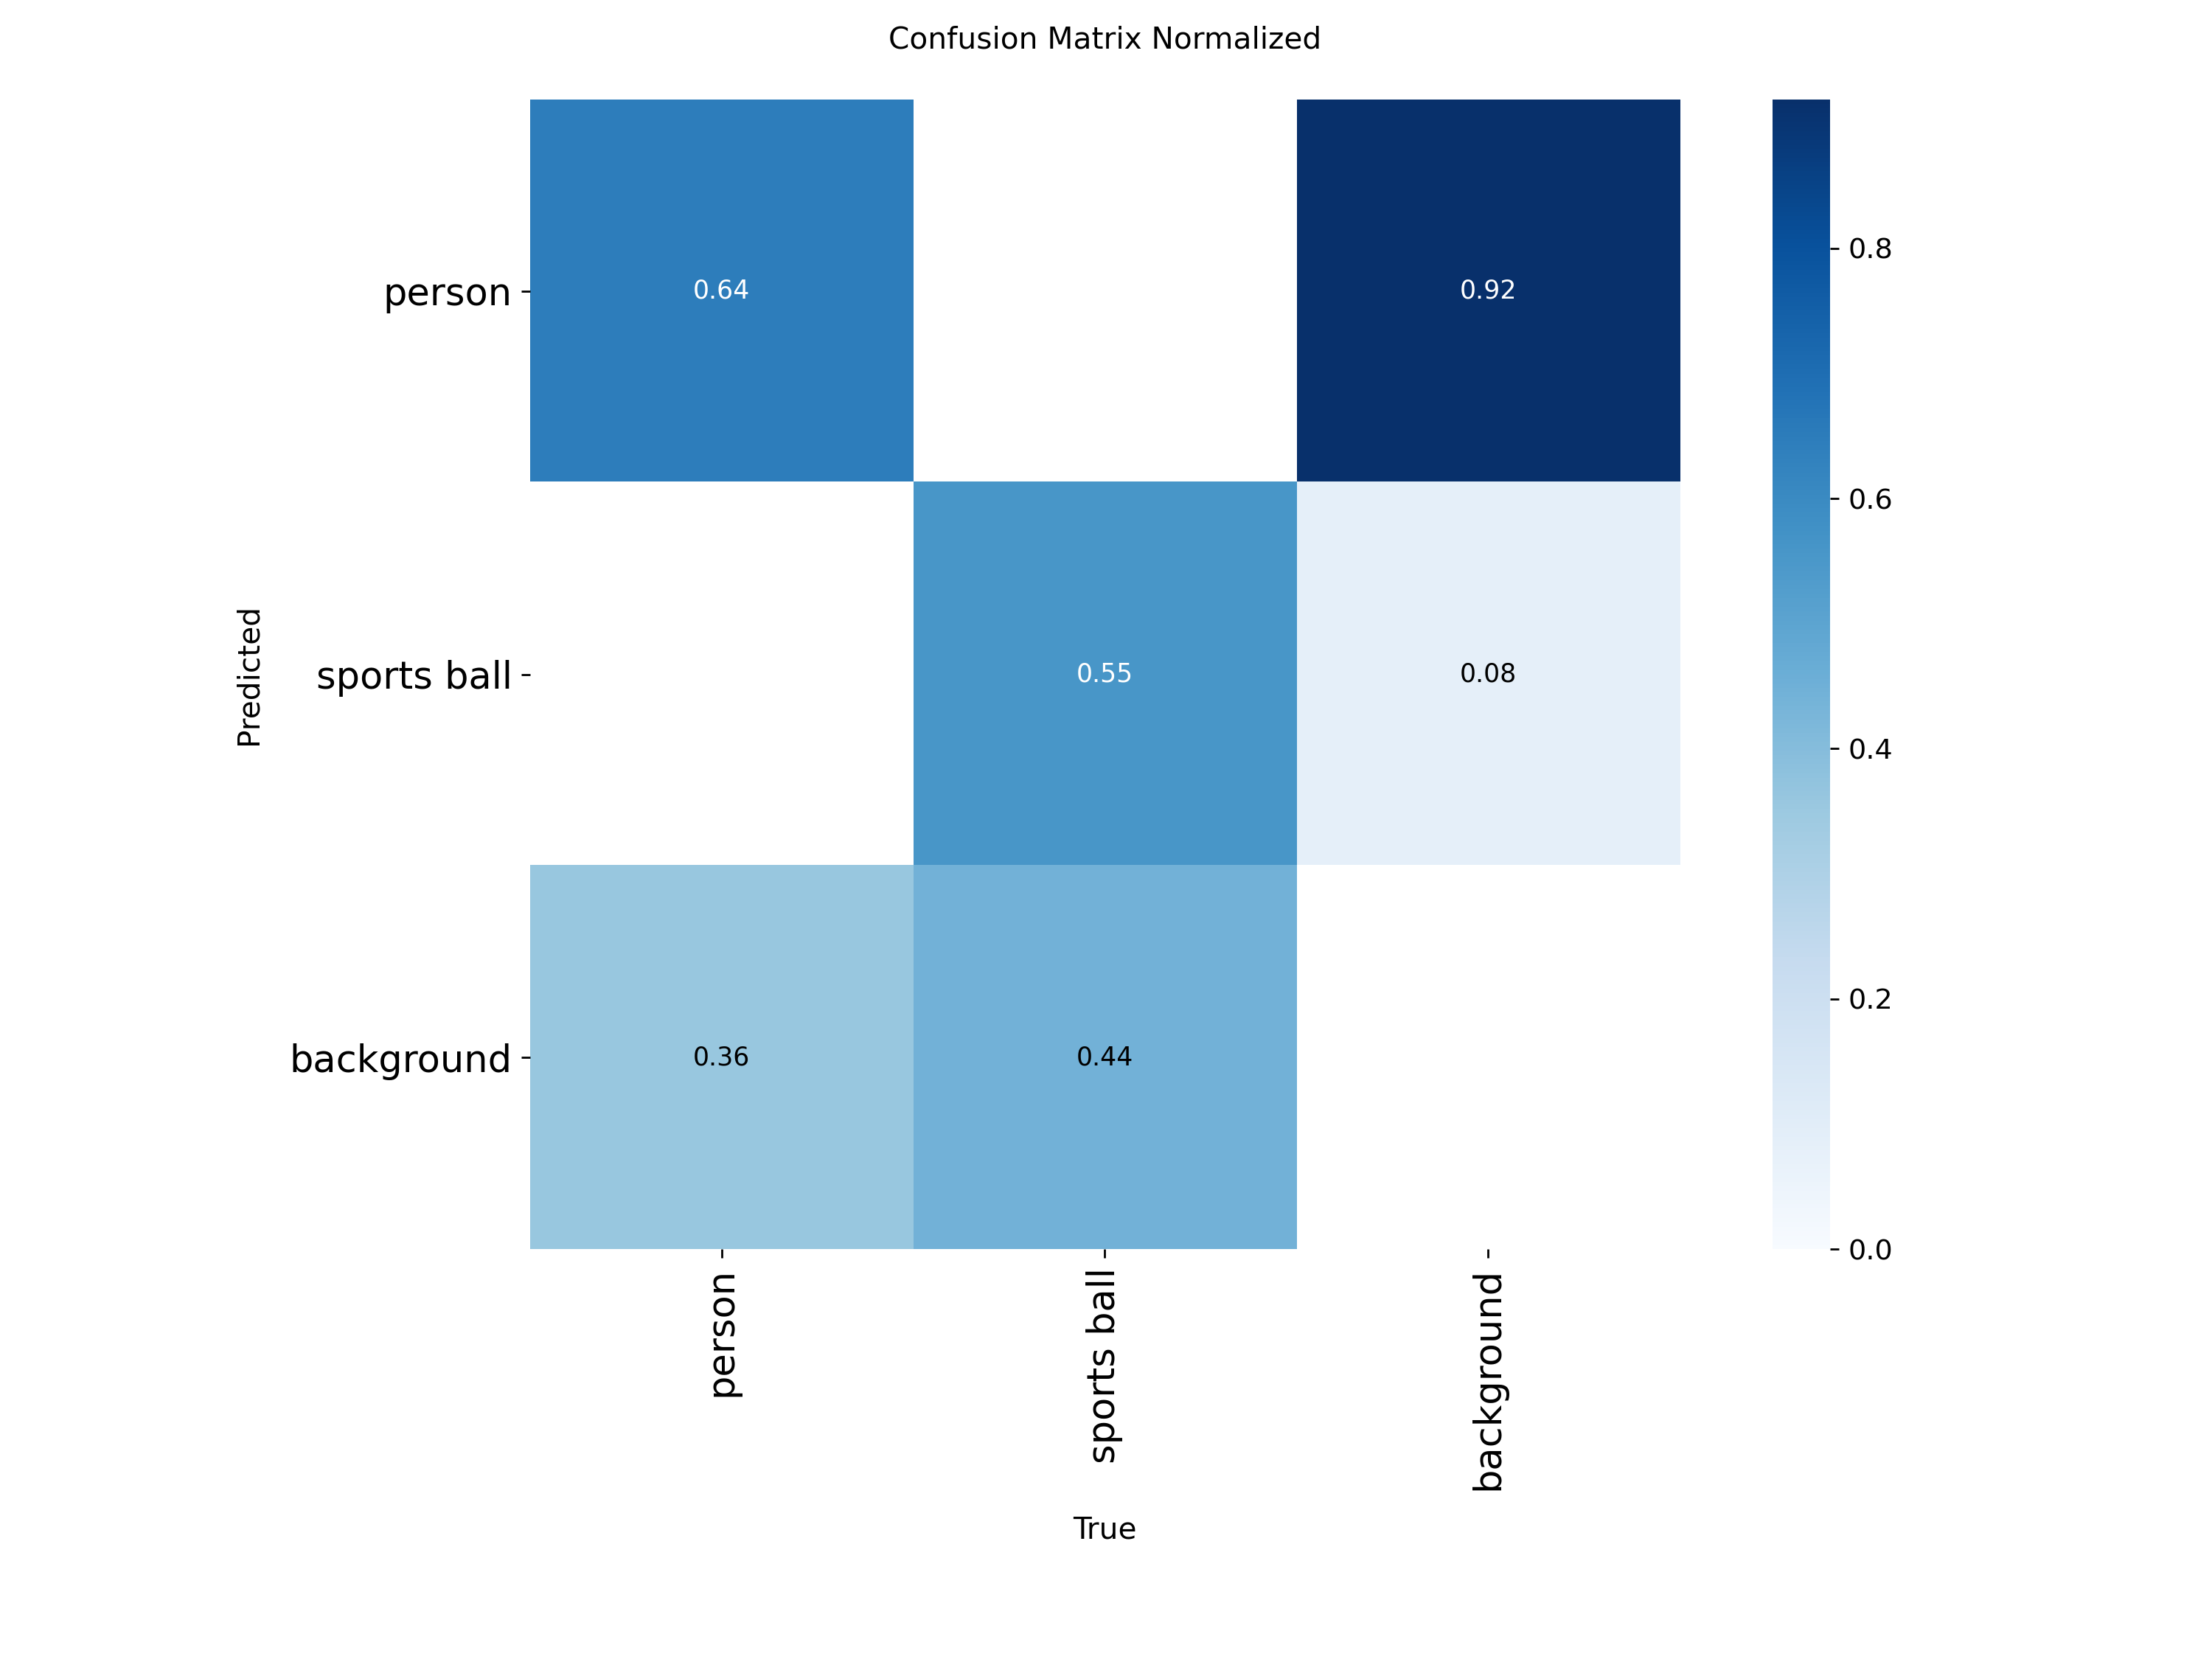

In [13]:
Image(filename=f'runs/detect/yolov11n_coco_person_sportsball_val/confusion_matrix_normalized.png', width=600)

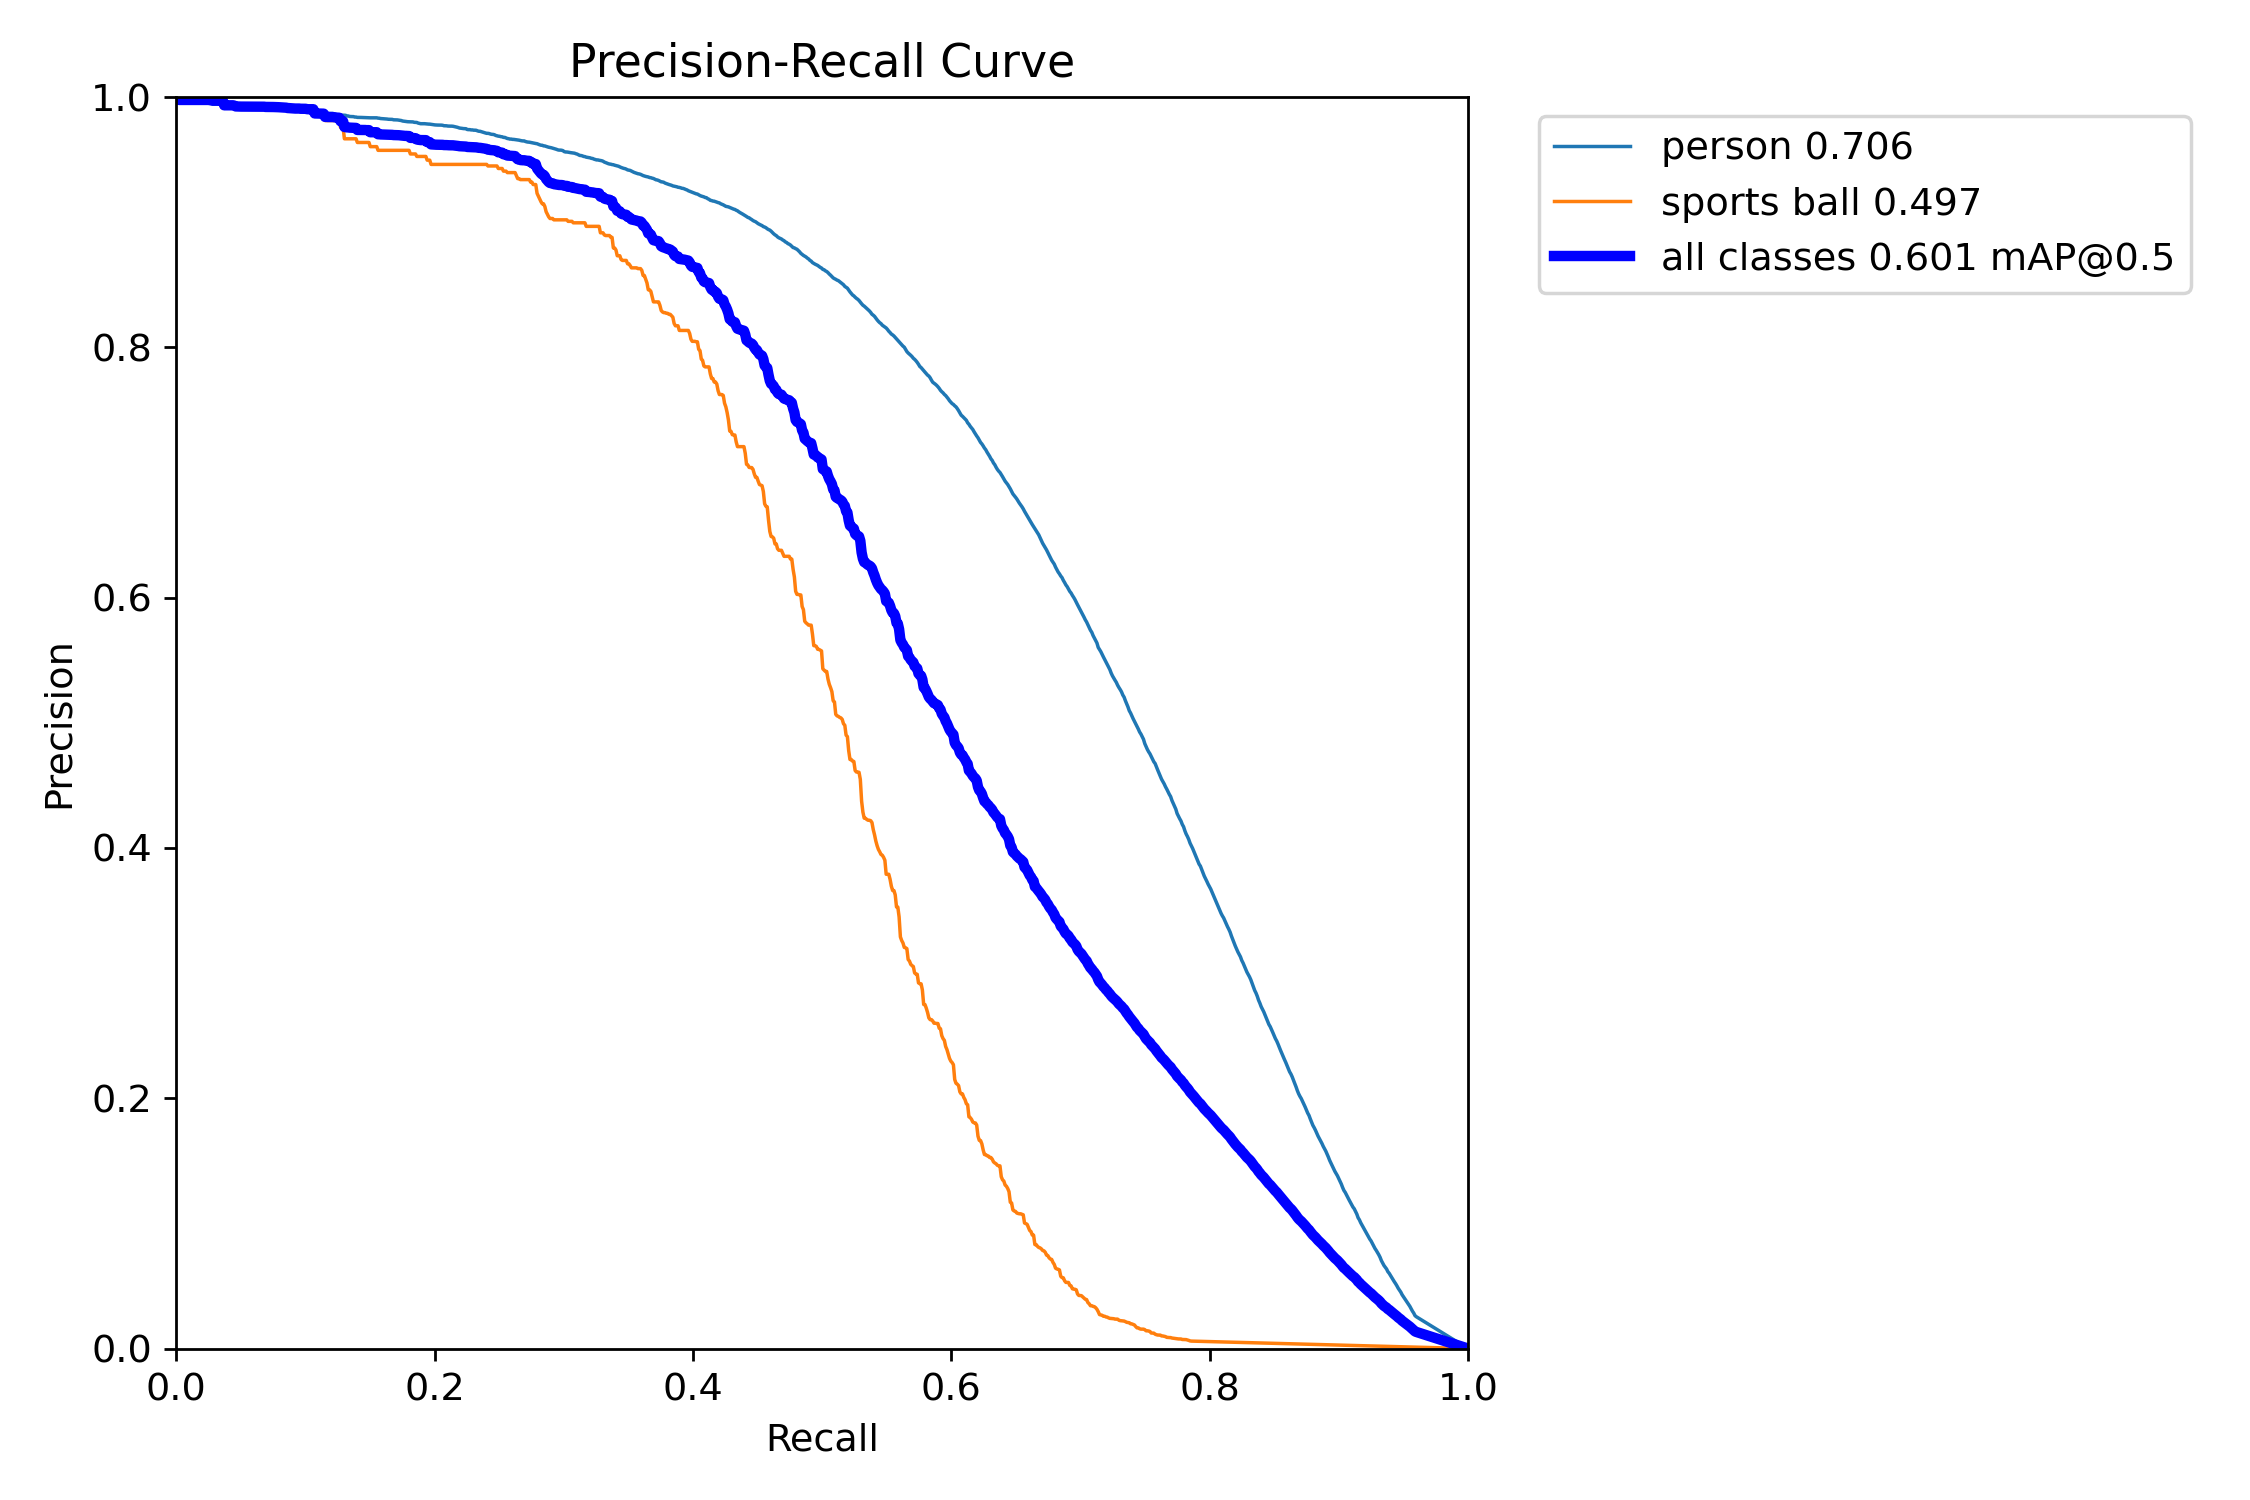

In [14]:
Image(filename=f'runs/detect/yolov11n_coco_person_sportsball_val/PR_curve.png', width=600)